# Code for experiment "Snapshot ensembles: Train 1, get M for free"
### By scheduling the learning rate so that the model converges at multiple local minimas, we are able to obtain different models in one training process.

In [1]:
import time
import utils
import os
import numpy as np
import math
import gc
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import np_utils
from keras import backend as K

Using TensorFlow backend.


## Disable tensorflow messages

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Model architecture

In [3]:
def build_model(num_classes=10):
    # Define the model
    model = Sequential()
    model.add(Convolution2D(48, 3, 3, border_mode='same', input_shape=(32, 32, 3)))
    model.add(Activation('relu'))
    model.add(Convolution2D(48, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Convolution2D(96, 3, 3, border_mode='same'))
    model.add(Activation('relu'))
    model.add(Convolution2D(96, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Convolution2D(192, 3, 3, border_mode='same'))
    model.add(Activation('relu'))
    model.add(Convolution2D(192, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

## Learning rate scheduling

In [4]:
def calculate_lr(alpha0, iteration, nb_iterations, nb_cycles):
    """
    :param alpha0:
    :param iteration: t
    :param nb_iterations: T
    :param nb_cycles: M
    :return: learning rate
    """
    return 0.5 * alpha0 * (1 + math.cos(1 / math.ceil(nb_iterations / nb_cycles) *
                                        math.pi * (iteration - 1 % math.ceil(nb_iterations / float(nb_cycles)))))

## Read dataset

In [5]:
dataset = 10
if dataset == 10:
    x_all, y_all, x_test, y_test = utils.read_data_cifar10()
elif dataset == 100:
    x_all, y_all, x_test, y_test = utils.read_data_cifar100()

## Train snapshot ensembles

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), padding="same", input_shape=(32, 32, 3...)`
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
  if sys.path[0] == '':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3), padding="same")`
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel_lau

Epoch 1: acc=0.11 loss=2.30 val acc=0.10 val loss=2.30
Epoch 2: acc=0.11 loss=2.30 val acc=0.10 val loss=2.30
Epoch 3: acc=0.11 loss=2.30 val acc=0.10 val loss=2.30
Epoch 4: acc=0.10 loss=2.30 val acc=0.13 val loss=2.29
Epoch 5: acc=0.12 loss=2.29 val acc=0.11 val loss=2.30
Epoch 6: acc=0.13 loss=2.28 val acc=0.24 val loss=2.15
Epoch 7: acc=0.22 loss=2.12 val acc=0.23 val loss=2.07
Epoch 8: acc=0.27 loss=1.97 val acc=0.32 val loss=1.80
Epoch 9: acc=0.31 loss=1.85 val acc=0.38 val loss=1.66
Epoch 10: acc=0.36 loss=1.74 val acc=0.40 val loss=1.65
Epoch 11: acc=0.40 loss=1.64 val acc=0.44 val loss=1.51
Epoch 12: acc=0.44 loss=1.55 val acc=0.50 val loss=1.37
Epoch 13: acc=0.47 loss=1.48 val acc=0.54 val loss=1.26
Epoch 14: acc=0.50 loss=1.41 val acc=0.57 val loss=1.21
Epoch 15: acc=0.52 loss=1.35 val acc=0.59 val loss=1.15
Epoch 16: acc=0.54 loss=1.29 val acc=0.58 val loss=1.18
Epoch 17: acc=0.57 loss=1.23 val acc=0.63 val loss=1.04
Epoch 18: acc=0.58 loss=1.18 val acc=0.64 val loss=1.00
E

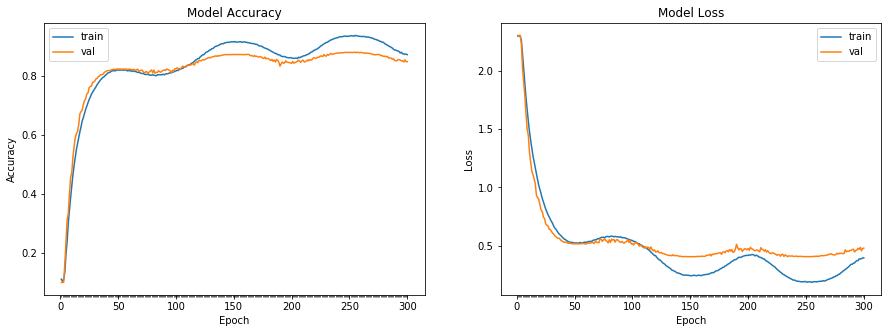

Using 2 last networks got 0.874433 accuracy
Using 3 last networks got 0.874367 accuracy
Using 4 last networks got 0.877100 accuracy
Using 5 last networks got 0.875067 accuracy
Using 6 last networks got 0.874733 accuracy


In [6]:
T = 300
M = 6
alpha0 = 0.1

acc_dict = {x: [] for x in range(2, M+1)}
train_time = []
acc = [0.0] * T
val_acc = [0.0] * T
loss = [0.0] * T
val_loss = [0.0] * T
kf = StratifiedKFold(n_splits=3, shuffle=True)
for train, test in kf.split(x_all, y_all):
    x_train = x_all[train]
    x_val = x_all[test]
    y_train = y_all[train]
    y_val = y_all[test]

    y_train = np_utils.to_categorical(y_train, dataset)
    y_val = np_utils.to_categorical(y_val, dataset)

    MODEL = build_model()
    DATAGEN = ImageDataGenerator(zoom_range=0.2,
                                 horizontal_flip=True)
    start = time.time()
    for t in range(1, T+1):
        sgd = optimizers.SGD(lr=calculate_lr(alpha0, t, T, M))
        MODEL.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        model_info = MODEL.fit_generator(DATAGEN.flow(x_train, y_train, batch_size=64), epochs=1,
                                         validation_data=(x_val, y_val), verbose=0)
        acc[t-1] += model_info.history["acc"][0]
        val_acc[t-1] += model_info.history["val_acc"][0]
        loss[t-1] += model_info.history["loss"][0]
        val_loss[t-1] += model_info.history["val_loss"][0]
        print "Epoch %d: acc=%0.2f loss=%0.2f val acc=%0.2f val loss=%0.2f" % \
              (t, model_info.history["acc"][0], model_info.history["loss"][0],
               model_info.history["val_acc"][0], model_info.history["val_loss"][0])
        if t % math.ceil(T / M) == 0:
            print " Save model"
            MODEL.save("models/model%d.h5" % t)

    utils.predict_using_snapshot_ensembles(x_test, y_test, acc_dict)
    end = time.time()
    train_time.append(end - start)
    K.clear_session()

# test time
print "Model took %0.3f seconds to train" % (sum(train_time) / len(train_time))

# plot model history
utils.plot_model_history_by_list(np.array(acc)/kf.n_splits, np.array(val_acc)/kf.n_splits,
                                 np.array(loss)/kf.n_splits, np.array(val_loss)/kf.n_splits, show=True)

# compute test accuracy
for a in acc_dict:
    print "Using %d last networks got %f accuracy" % (a, sum(acc_dict[a])/len(acc_dict[a]))

# free memory
x_train = None
x_val = None
y_train = None
y_val = None